# Neural Networks for Count Data 

Redo the Poisson Regression for the fish data set, now with keras. From the previous exercise:

## Fish Data Set

The following data-set contains the number of Fish a group of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish $y$ caught by a fishing party. We have a small data set, of 250 groups, which visited a state park and provided the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

Split the data set into a training set and testset. Use the first 200 entries for training, the remaining 50 for testing. See below for code how to read the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

In [2]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
# np.savez('fishing.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#https://github.com/ioskn/mldl_htwg/raw/master/data/fishing.npz
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
X_train = d['Xt'] #"livebait","camper","persons","child"
X_test = d['Xte']
y_train = d['yt']
y_test = d['yte']
pd.DataFrame(X_train[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


## Results from the Machine Learning excercise, we had. 

### LinearRegression
Skipped, see original notebook.

### Poisson

This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability on negative number of fish is fishy too. A Gaussian as a CPD is therefore not ideal. Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 -log(p(k)) = \mu  - k \cdot \log(\mu) + log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$. Nown in the Poissonian, $\mu_i$ needs to be positive. We therefore pipe $\beta^T \cdot x_i$ through an exponential first to make it positive and can so determine $\mu_i=exp(\beta^T \cdot x_i)$.

Use a gradient descent approach to find the solution for the parameters. Calculate the RMSE and the NLL on the test set.

Hint: On the trainingset the NLL for the parameter values (1,1,1,1,1) should be approx 1508 and the gradient 

In [7]:
import math
def NLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    ret = np.zeros_like(mu)
    for i in range(ret.shape[0]):
        ret[i] = mu[i] - y_train[i]*np.log(mu[i]) #+ np.log(1.0*math.factorial(int(y_train[i])))
    return np.mean(ret)
w = np.ones(5)
NLL(y_train, Xd,w)

np.float64(1500.7030430487873)

In [8]:
def gradNLL(yt, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    #print(mu.shape)
    ret = np.zeros_like(Xd)
    for i in range(Xd.shape[0]):
        mux = Xd[i] * mu[i]
        ret[i] = mux - yt[i] * Xd[i]
    return np.mean(ret, axis=0)

NLL(y_train, Xd,np.ones(5))
np.round(gradNLL(y_train, Xd,np.ones(5)),2)
#1518.61, 1403.99, 1171.02, 5701.91, 3258.7

array([1518.61, 1403.99, 1171.02, 5701.91, 3258.7 ])

In [9]:
from tqdm import tqdm 
w = np.ones(5)
hist = []
for i in tqdm(range(10000)):
    if (i % 10 == 0):
        hist.append(NLL(y_train, Xd,w))
    w = w - 0.001 * gradNLL(y_train, Xd,w)
w, NLL(y_train, Xd,w)

100%|██████████| 10000/10000 [00:03<00:00, 3042.23it/s]


(array([-1.74007527,  0.56500613,  0.66091814,  0.93220074, -1.62023821]),
 np.float64(-3.9020104748449365))

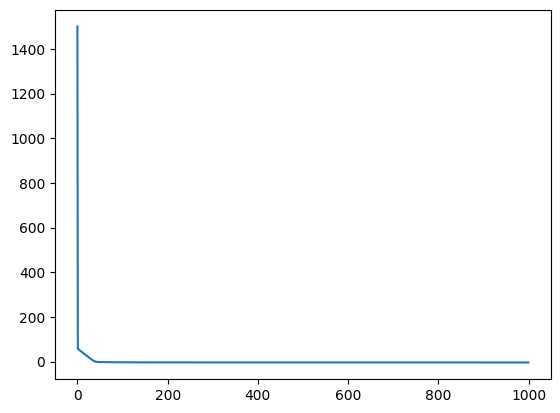

In [10]:
plt.plot(hist)
#plt.ylim(0,5)
plt.show()

In [11]:
mupred = np.exp(np.matmul(Xdt, w))
np.sqrt(np.mean((mupred - y_test)**2)), NLL(y_test, Xdt,w)

(np.float64(7.389176645536159), np.float64(-4.122861227093828))

## a) Simple NN w/o a hidden layer 

Redo the analysis from above using Keras. Use a NN with a single output node determining the rate of poisson distribution. Implement the negative log likelihood as loss function. Use a custom loss function and not the built-in loss function for poisson distribution in Keras.

**Tasks:**
1.  **Data Preparation**: Cast the data (`X_train`, `y_train`, etc.) to `float32`. Keras/Torch expects float32.
2.  **Custom Loss Function**: Implement the Poisson Negative Log Likelihood (NLL) loss function `poisson_nll(y_true, y_pred)`. 
    *   Recall: $NLL = \mu - k \cdot \log(\mu) + \log(k!)$.
    *   Since we want to minimize the loss, we can ignore the constant term $\log(k!)$ as it doesn't depend on the model parameters.
    *   So, minimize: $\mu - y_{true} \cdot \log(\mu)$.
    *   **Hint**: Use `keras.ops` (aliased as `ops`) for mathematical operations like `ops.mean`, `ops.exp`, `ops.log` to be backend-agnostic.
3.  **Model Definition**: Define a simple Keras model (Sequential) with:
    *   One Dense layer with 1 unit.
    *   **Important**: The output $\mu$ must be positive. Use an exponential activation function (e.g., `activation="exp"` or `activation=ops.exp` if defining a custom layer, or simply apply exp to the linear output).
4.  **Training**: Compile the model with your custom loss and an optimizer (e.g., Adam). Fit the model on the training data.
5.  **Evaluation**: Calculate the RMSE and NLL on the test set and plot the results (Predicted vs Observed), similar to the Linear Regression part.

In [12]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
import jax.numpy as jnp

os.environ["KERAS_BACKEND"] = "jax" # Use Torch backend as requested
import keras
import keras.ops as ops
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Add bias term if using a simple Dense layer without bias, 
# but Keras Dense layer has bias by default, so we can just use X_train directly if we want.
# However, the previous example used Xd (with ones). Let's stick to X_train for Keras 
# and let the Dense layer handle the bias.

# 2. Custom Loss Function
def poisson_nll(y_true, y_pred):
    # TODO: Implement the Poisson NLL loss
    # loss = mu - y_true * log(mu)
    # y_pred is mu
    return 0.0 # TODO: Replace with correct formula using ops

# 3. Model Definition
model = keras.Sequential([
    # TODO: Add a Dense layer with 1 unit and exponential activation
    # keras.layers.Dense(1, activation=...)
])

# 4. Training
# model.compile(optimizer='adam', loss=poisson_nll)
# history = model.fit(X_train, y_train, epochs=1000, verbose=0)

# 5. Evaluation
# y_pred = model.predict(X_test)
# Calculate RMSE and NLL on test set
# Plot results

In [13]:
# Build a NN mimicking the fish poisson problem, train it and evaluate it

Training time: 1.8284142017364502
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 7.833114147186279
NLL: -3.6593122482299805


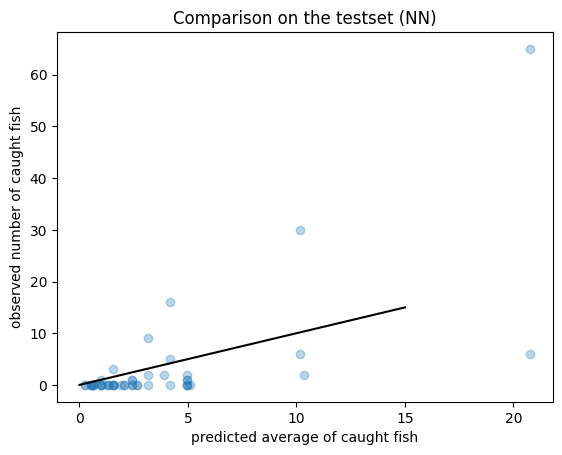

In [14]:
# STOP: REMOVE THIS CELL BEFORE SHARING WITH STUDENTS
# Solution

# 1. Data Preparation
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# 2. Custom Loss Function
def poisson_nll(y_true, y_pred):
    # loss = mu - y_true * log(mu)
    return ops.mean(y_pred - y_true * ops.log(y_pred))

# 3. Model Definition
model = keras.Sequential([
    keras.layers.Dense(1, activation="exponential")
])

# 4. Training
model.compile(optimizer='adam', loss=poisson_nll)
start = time.time()
history = model.fit(X_train, y_train, epochs=1000, verbose=0)
end = time.time()
print(f"Training time: {end - start}")

# 5. Evaluation
y_pred = model.predict(X_test)
sigma_hat_2_nn = np.mean((y_test - y_pred.flatten())**2)
rmse_nn = np.sqrt(sigma_hat_2_nn)
# For NLL, we can reuse the function or calculate manually. 
# Note: The task asked for NLL on test set. The custom loss function returns the mean NLL.
# We need to be careful about the shape for the loss function if calling it directly with numpy arrays,
# but since we imported ops, we can use it, or just use numpy.
nll_nn = np.mean(y_pred - y_test.reshape(-1, 1) * np.log(y_pred))

print(f"RMSE: {rmse_nn}")
print(f"NLL: {nll_nn}")

plt.scatter(y_pred, y_test, alpha=0.3)
plt.plot([0, 15], [0, 15], c="black")
plt.title('Comparison on the testset (NN)')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

In [15]:
## b) Pure PyTorch Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import time

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Model
class PoissonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = nn.Linear(X_train.shape[1], 1)
    
    def forward(self, x):
        # Exponential activation for positive output
        return torch.exp(self.dense(x))

model_torch = PoissonModel()

# Loss
def poisson_nll_torch(y_true, y_pred):
    return torch.mean(y_pred - y_true * torch.log(y_pred))

# Optimizer
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

# Training Loop
start_time = time.time()
for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model_torch(X_train_torch)
    loss = poisson_nll_torch(y_train_torch.reshape(-1, 1), y_pred)
    loss.backward()
    optimizer.step()
torch_time = time.time() - start_time
print(f"PyTorch Training Time: {torch_time:.4f} seconds")
print(f"NLL: {poisson_nll_torch(y_train_torch.reshape(-1, 1), y_pred).item():.4f}")

PyTorch Training Time: 1.1666 seconds
NLL: -3.9867


In [16]:
## c) Pure JAX Implementation
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
import jax.numpy as jnp

# Convert data to JAX arrays
X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train).reshape(-1, 1)

# Initialize parameters
key = jax.random.PRNGKey(0)
w = jax.random.normal(key, (X_train.shape[1], 1))
b = jax.random.normal(key, (1,))
params = {'w': w, 'b': b}

# Model
def model_jax(params, x):
    return jnp.exp(jnp.dot(x, params['w']) + params['b'])

# Loss
def poisson_nll_jax(params, x, y):
    y_pred = model_jax(params, x)
    return jnp.mean(y_pred - y * jnp.log(y_pred))

# Update step
@jax.jit
def update(params, x, y, lr=0.001):
    grads = jax.grad(poisson_nll_jax)(params, x, y)
    new_params = {
        'w': params['w'] - lr * grads['w'],
        'b': params['b'] - lr * grads['b']
    }
    return new_params

# Training Loop
start_time = time.time()
# JIT compile the update function by running it once
params = update(params, X_train_jax, y_train_jax)

for epoch in range(1000):
    params = update(params, X_train_jax, y_train_jax)
jax_time = time.time() - start_time
print(f"JAX Training Time: {jax_time:.4f} seconds")

JAX Training Time: 0.0428 seconds


In [18]:
## d) Speed Comparison

# Re-run Keras training for fair comparison
model_keras = keras.Sequential([
    keras.layers.Dense(1, activation="exponential")
])
model_keras.compile(optimizer='adam', loss=poisson_nll)

start_time = time.time()
model_keras.fit(X_train, y_train, epochs=1000, verbose=0)
keras_time = time.time() - start_time
print(f"Keras Training Time: {keras_time:.4f} seconds")

print("\n--- Summary ---")
print(f"PyTorch: {torch_time:.4f} s")
print(f"JAX:     {jax_time:.4f} s")
print(f"Keras:   {keras_time:.4f} s")


Keras Training Time: 1.7347 seconds

--- Summary ---
PyTorch: 1.1666 s
JAX:     0.0428 s
Keras:   1.7347 s
